In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Ignore all warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
from matplotlib import style

# setting style
style.available
style.use('ggplot')

In [3]:
df = pd.read_excel('Data/Telco_customer_churn.xlsx')

In [4]:
# View first five rows of the dataframe
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


Data Inspection

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


## Data Cleaning

In [7]:
# Check for missing values
missing_value = df.isnull().sum()
missing_value = missing_value[missing_value > 0]
missing_value

Churn Reason    5174
dtype: int64

In [8]:
df.shape

(7043, 33)

In [9]:
df.drop(['CustomerID', 'Country', 'State', 'Count', 'Churn Reason', 'Churn Label', 'Lat Long'], axis=1, inplace=True) 

In [10]:
# Check the shape of our data
df.shape

(7043, 26)

In [11]:
#check the data types of the colums
df.dtypes

City                  object
Zip Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Value            int64
Churn Score            int64
CLTV                   int64
dtype: object

In [12]:
# Identify columns that should be numeric
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Check if there are any non-numeric values in these columns
for col in numeric_columns:
    if df[col].apply(lambda x: isinstance(x, (str, object))).any():
        print(f"Non-numeric values found in column: {col}")

Non-numeric values found in column: Zip Code
Non-numeric values found in column: Latitude
Non-numeric values found in column: Longitude
Non-numeric values found in column: Tenure Months
Non-numeric values found in column: Monthly Charges
Non-numeric values found in column: Churn Value
Non-numeric values found in column: Churn Score
Non-numeric values found in column: CLTV


In [13]:
df.columns

Index(['City', 'Zip Code', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Value', 'Churn Score',
       'CLTV'],
      dtype='object')

In [14]:
# Create a function to check if a value can be converted to a float
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Apply the function to the 'Total Charges' column to identify non-numeric values
non_numeric_mask = df['Total Charges'].apply(lambda x: not is_numeric(x))

# Display the rows where 'Total Charges' contains non-numeric values
non_numeric_entries = df[non_numeric_mask]
print("Rows with non-numeric values in 'Total Charges':")
non_numeric_entries[['Total Charges']]

Rows with non-numeric values in 'Total Charges':


,Total Charges
2234,
2438,
2568,
2667,
2856,
4331,
4687,
5104,
5719,
6772,


In [15]:
# Convert numerical columns to numeric type
numeric_columns = [
    'Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges',
    'Total Charges', 'Churn Score', 'CLTV'
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert to numeric, handle errors

# Check for missing values
print(df.isnull().sum())

City                  0
Zip Code              0
Latitude              0
Longitude             0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
Churn Score           0
CLTV                  0
dtype: int64


In [16]:
# Impute missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
df[numeric_columns] = imputer.fit_transform(df[numeric_columns])

Label Encode Categorical variables

In [17]:
# Label encoding Categorical Variables
label_cols = ['Gender', 'City', 'Senior Citizen', 'Partner', 'Dependents', 
              'Phone Service', 'Multiple Lines', 'Online Security', 
              'Online Backup', 'Device Protection', 'Tech Support', 
              'Streaming TV', 'Streaming Movies', 'Paperless Billing', 
              ]

label_encoder = LabelEncoder()
for col in label_cols:
    df[col] = label_encoder.fit_transform(df[col])

One_Hot encode categorical variables like 'Internet Service', 'Contract', and 'Payment Method'


In [18]:
# One-hot encode 'Internet Service', 'Contract', and 'Payment Method'
df = pd.get_dummies(df, columns=['Internet Service', 'Contract', 'Payment Method'], drop_first=True)

Scale numeric features like 'Monthly Charge', 'Total Charges', and 'Churn Score'.

In [19]:
# Scaling numeric features
scaler = StandardScaler()
df[['Monthly Charges', 'Total Charges', 'Churn Score']] = scaler.fit_transform(df[['Monthly Charges', 'Total Charges', 'Churn Score']])

## Feature Engineering

In [20]:
#Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['CityCluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])

In [21]:
# Example logic for creating TenureGroup
df['TenureGroup'] = pd.cut(df['Tenure Months'], 
                           bins=[0, 12, 24, 48, 60, 72, 100], 
                           labels=['0-12', '12-24', '24-48', '48-60', '60-72', '72+'],
                           right=False)

In [22]:
# Display the first few rows to confirm the new feature
df[['Tenure Months', 'TenureGroup']].head()

,Tenure Months,TenureGroup
0,2.0,0-12
1,2.0,0-12
2,8.0,0-12
3,28.0,24-48
4,49.0,48-60


In [23]:
# Define the mapping for manual encoding
tenure_mapping = {'0-12': 1, '12-24': 2, '24-48': 3, '48-60': 4, '60-72': 5, '72+': 6}

# Apply the mapping to the 'TenureGroup' column
df['TenureGroup'] = df['TenureGroup'].map(tenure_mapping)


In [24]:
# Display the first few rows to confirm the new feature
df[['Tenure Months', 'TenureGroup']].head()

,Tenure Months,TenureGroup
0,2.0,1
1,2.0,1
2,8.0,1
3,28.0,3
4,49.0,4


In [25]:
# Create an interaction feature for total payment behavior
df['TotalPayment'] = df['Monthly Charges'] * df['Tenure Months']

# Display the first few rows to confirm the new feature
df[['Monthly Charges', 'Tenure Months', 'TotalPayment']].head()

,Monthly Charges,Tenure Months,TotalPayment
0,-0.362660,2.0,-0.725321
1,0.197365,2.0,0.394730
2,1.159546,8.0,9.276366
3,1.330711,28.0,37.259902
4,1.294151,49.0,63.413411


In [26]:
df.isnull().sum()

City                                      0
Zip Code                                  0
Latitude                                  0
Longitude                                 0
Gender                                    0
Senior Citizen                            0
Partner                                   0
Dependents                                0
Tenure Months                             0
Phone Service                             0
Multiple Lines                            0
Online Security                           0
Online Backup                             0
Device Protection                         0
Tech Support                              0
Streaming TV                              0
Streaming Movies                          0
Paperless Billing                         0
Monthly Charges                           0
Total Charges                             0
Churn Value                               0
Churn Score                               0
CLTV                            

In [27]:
# Check for missing values
missing_value = df.isnull().sum()
missing_value = missing_value[missing_value > 0]
missing_value

Series([], dtype: int64)

There are no missing values

## Data Modelling

In [28]:
# Get feature and Target Variable
X = df.drop('Churn Value', axis=1)  # Features
y = df['Churn Value']  # Target variable

In [29]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Make predications on the X_test
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC and Precision-Recall curves

# Check the accuracy of the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1009
           1       0.91      0.84      0.87       400

    accuracy                           0.93      1409
   macro avg       0.92      0.90      0.91      1409
weighted avg       0.93      0.93      0.93      1409



In [32]:
# Get feature importances
importances = model.feature_importances_

In [33]:
# Create a DataFrame with feature names and their corresponding importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


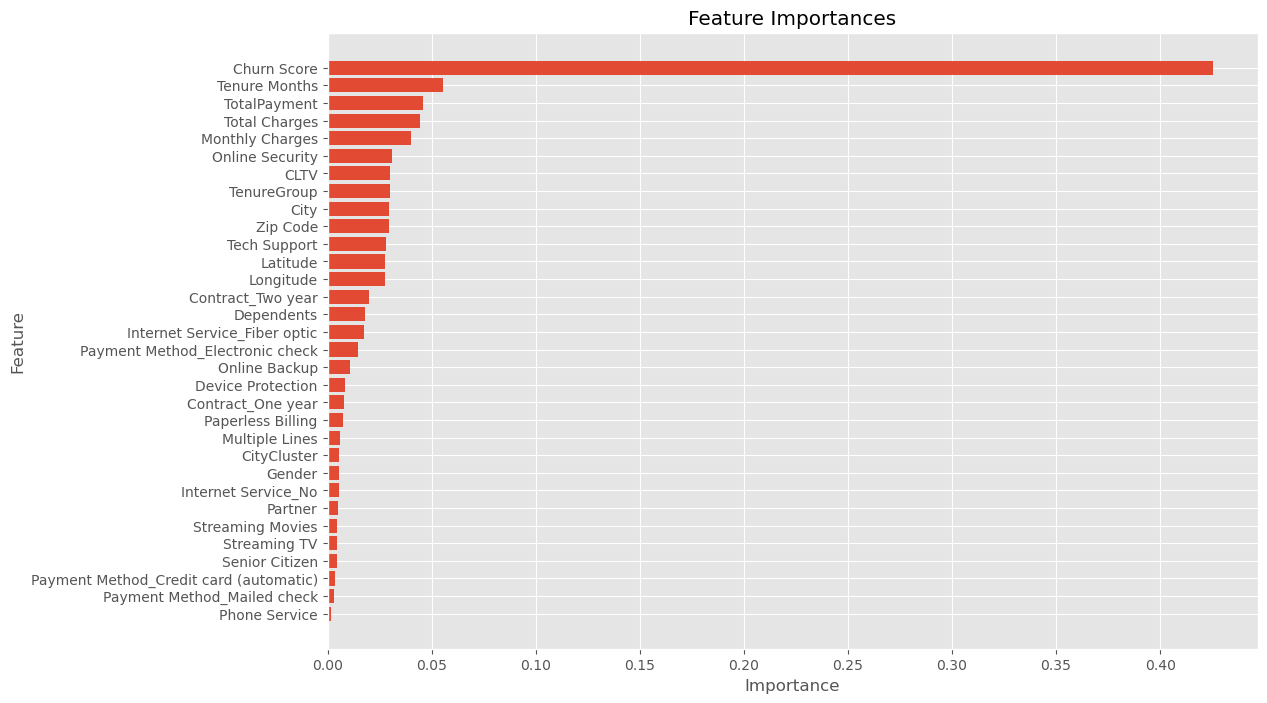

In [34]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

### Hyperparameter Tuning 

In [35]:
# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [36]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("\nBest Parameters from Grid Search:")
print(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters from Grid Search:
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}


In [37]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.9329079071585389


In [38]:
# Use the best model
best_rf = grid_search.best_estimator_

# Predict with the best model
y_pred_best = best_rf.predict(X_test)

print(f"Accuracy with best parameters: {accuracy_score(y_test, y_pred_best):.2f}")
print(classification_report(y_test, y_pred_best))

Accuracy with best parameters: 0.93
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1009
           1       0.91      0.84      0.88       400

    accuracy                           0.93      1409
   macro avg       0.93      0.91      0.92      1409
weighted avg       0.93      0.93      0.93      1409



In [39]:
# Cross-validation
cv_scores = cross_val_score(grid_search.best_estimator_, X, y, cv=5, scoring='accuracy')
print(f"\nCross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")


Cross-Validation Scores: [0.92547906 0.9325763  0.93044713 0.93252841 0.92471591]
Mean CV Accuracy: 0.93


## Error Analysis

In [40]:
# Error Analysis
errors = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_prob})
errors['Correct'] = errors['Actual'] == errors['Predicted']
print("\nError Analysis:")
errors[errors['Correct'] == False].head()


Error Analysis:


,Actual,Predicted,Probability,Correct
2892,0,1,0.58,False
1084,1,0,0.16,False
177,1,0,0.33,False
5556,0,1,0.66,False
1075,1,0,0.19,False


## Error Analysis

Below is a summary of some prediction errors made by the model, highlighting the cases where predictions diverged from actual values:

### Error Cases

1. **Case 1: False Positive**
   - **Prediction:** Churn (1)
   - **Actual Value:** No Churn (0)
   - **Prediction Probability:** 0.58
   - **Observation:** The model predicted a churn, but the customer did not actually churn.
   - ![False Positive](https://via.placeholder.com/150?text=False+Positive)

2. **Case 2: False Negative**
   - **Prediction:** No Churn (0)
   - **Actual Value:** Churn (1)
   - **Prediction Probability:** 0.16
   - **Observation:** The model predicted no churn, but the customer actually churned.
   - ![False Negative](https://via.placeholder.com/150?text=False+Negative)

3. **Case 3: False Negative**
   - **Prediction:** No Churn (0)
   - **Actual Value:** Churn (1)
   - **Prediction Probability:** 0.33
   - **Observation:** Similar to Case 2, the model predicted no churn when the customer did churn, though with a slightly higher probability.
   - ![False Negative](https://via.placeholder.com/150?text=False+Negative)

4. **Case 4: False Positive**
   - **Prediction:** Churn (1)
   - **Actual Value:** No Churn (0)
   - **Prediction Probability:** 0.66
   - **Observation:** The model incorrectly predicted churn, with a higher probability of churn.
   - ![False Positive](https://via.placeholder.com/150?text=False+Positive)

5. **Case 5: False Negative**
   - **Prediction:** No Churn (0)
   - **Actual Value:** Churn (1)
   - **Prediction Probability:** 0.19
   - **Observation:** The model predicted no churn, but the customer actually churned, with a low probability of churn.
   - ![False Negative](https://via.placeholder.com/150?text=False+Negative)

### Summary

- **False Positives:** Instances where the model predicted a churn, but the actual outcome was no churn.
- **False Negatives:** Instances where the model predicted no churn, but the customer did churn.

This analysis helps in understanding where the model may need adjustments to improve its predictive accuracy.


In [41]:
# Additional Evaluation Metrics
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC: {roc_auc:.2f}")

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.2f}")


ROC AUC: 0.97
Precision-Recall AUC: 0.94


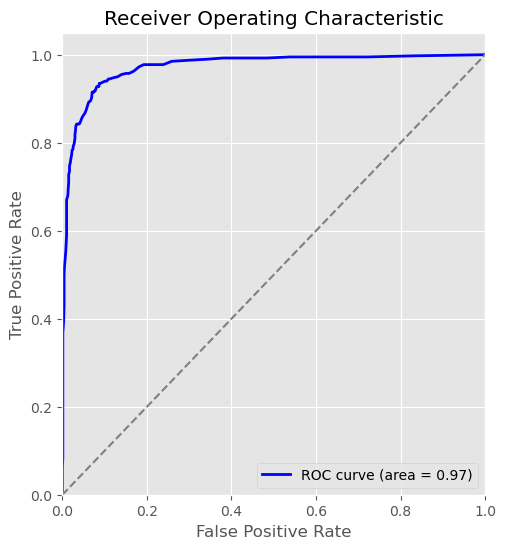

In [42]:
# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

The area under the ROC curve (AUC) is 0.97, which indicates that the model has a high level of accuracy in distinguishing between the classes.

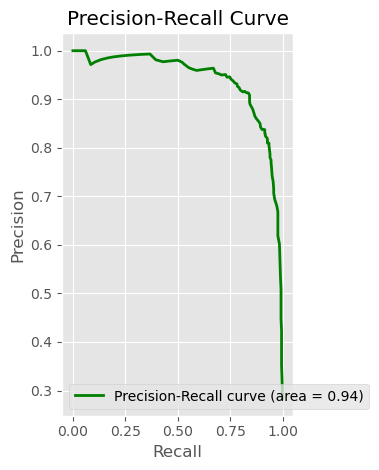

In [43]:
# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

The area under the Precision-Recall curve is 0.94, indicating that the model maintains a good balance between precision and recall.